In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("Suicide_Detection.csv")

# Drop Unnamed: 0 if not needed
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Basic info
print(df.info())
print("\nDataset shape:", df.shape)
print("\nFirst rows:\n", df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB
None

Dataset shape: (232074, 2)

First rows:
                                                 text        class
0  Ex Wife Threatening SuicideRecently I left my ...      suicide
1  Am I weird I don't get affected by compliments...  non-suicide
2  Finally 2020 is almost over... So I can never ...  non-suicide
3          i need helpjust help me im crying so hard      suicide
4  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [72]:
#missing values 
print(df.isnull().sum())

text           0
class          0
text_length    0
dtype: int64


In [73]:
#count 
print(df['class'].value_counts())

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_6140\4121423253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='Set2')


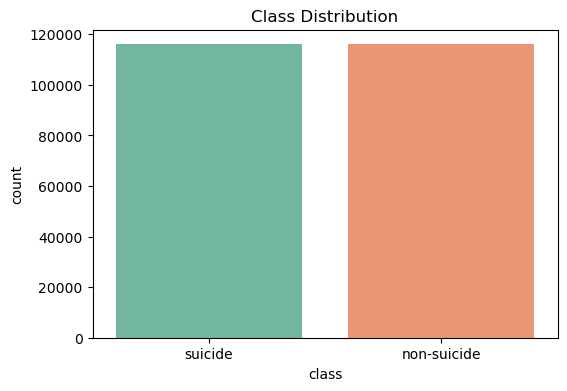

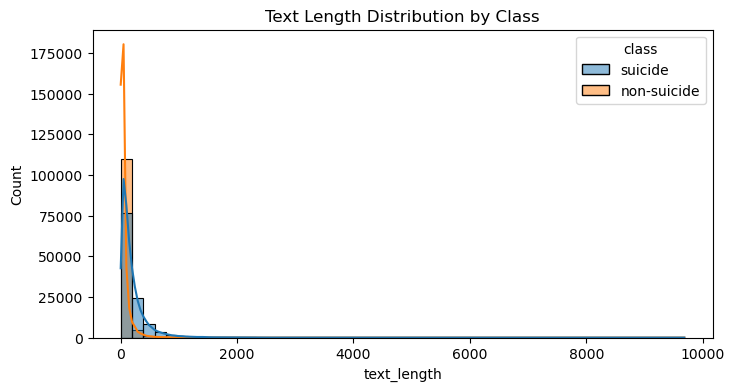

In [2]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='Set2')
plt.title("Class Distribution")
plt.show()

# Text length distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='text_length', hue='class', bins=50, kde=True)
plt.title("Text Length Distribution by Class")
plt.show()

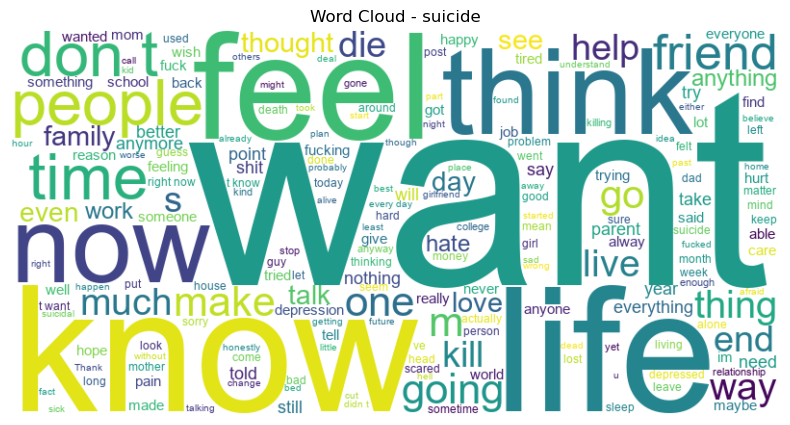

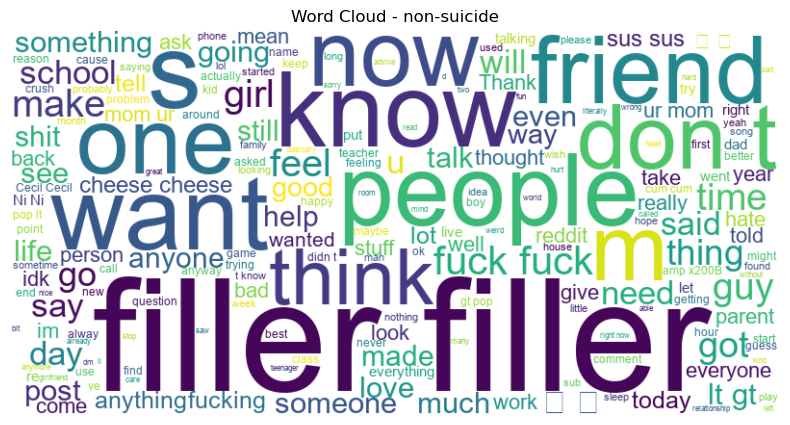

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

font_path = r"C:\Windows\Fonts\arial.ttf"

for c in df['class'].unique():
    text_all = " ".join(df[df['class']==c]['text'].astype(str))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        font_path=font_path,
        prefer_horizontal=1.0
    ).generate(text_all)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {c}")
    plt.show()


## BASELINE MODEL

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['class'], test_size=0.2, random_state=42, stratify=df['class']
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Baseline model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = lr_model.predict(X_test_tfidf)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     23208
     suicide       0.94      0.92      0.93     23207

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415


Confusion Matrix:
 [[21826  1382]
 [ 1795 21412]]


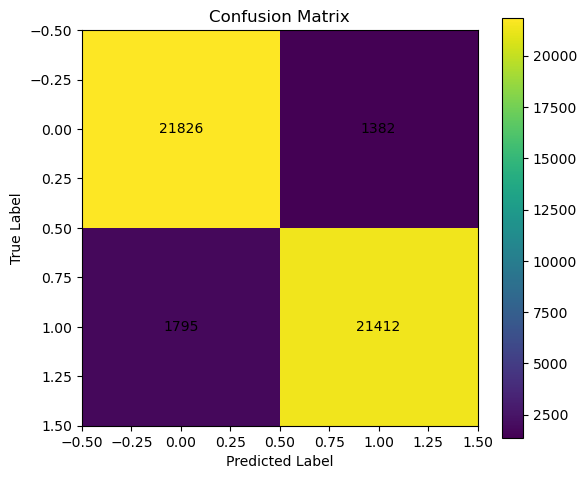

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

label_map = {"non-suicide": 0, "suicide": 1}

# Convert both y_test and y_pred
y_test_numeric = [label_map[label] for label in y_test]
y_pred_numeric = [label_map[label] for label in y_pred]

# Compute confusion matrix
cm = confusion_matrix(y_test_numeric, y_pred_numeric)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add numeric values to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


## DL - BiLSTM

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['class'])  # suicide=1, non-suicide=0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Tokenization
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [12]:
#Model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(32, activation='relu'))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(1, activation='sigmoid'))

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = bilstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=3,
    batch_size=64
)

loss, acc = bilstm_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 344s 112ms/step - accuracy: 0.9242 - loss: 0.2063 - val_accuracy: 0.9395 - val_loss: 0.1689
Epoch 2/3
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 335s 115ms/step - accuracy: 0.9475 - loss: 0.1472 - val_accuracy: 0.9412 - val_loss: 0.1624
Epoch 3/3
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 332s 114ms/step - accuracy: 0.9574 - loss: 0.1184 - val_accuracy: 0.9385 - val_loss: 0.1675
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9385 - loss: 0.1675
Test Accuracy: 0.9385


Our novelty lies in moving from flat feature-based ML methods to a deep learning architecture (BiLSTM) that captures bidirectional context, sequential dependencies, and nuanced semantic features of social media posts related to suicide, while also using dropout for generalization.

# Comparative Evaluation Using Sentences from Dataset and other External sources

In [68]:

# Sample sentences you want to test

sample_sentences = [
    "Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice...",
    "Am I weird I don't get affected by compliments if it's coming from someone I know...",
    "Finally 2020 is almost over... So I can never hear '2020 has been a bad year' ever again.",
    "i need helpjust help me im crying so hard",
    "I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid..."
]

# Label map
label_map = {0: "non-suicide", 1: "suicide"}


# LR prediction using your existing trained model

def predict_lr(sentences):
    tfidf_features = vectorizer.transform(sentences)
    preds = lr_model.predict(tfidf_features)
    preds_num = [1 if p == "suicide" else 0 for p in preds]
    return preds_num


# BiLSTM prediction using your trained model

def predict_bilstm(sentences):
    seq = tokenizer.texts_to_sequences(sentences)
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    probs = bilstm_model.predict(pad)
    preds = (probs > 0.5).astype(int).flatten()
    return preds.tolist()


# Compare model predictions in a dictionary

def compare_models(sentences):
    lr_preds = predict_lr(sentences)
    lstm_preds = predict_bilstm(sentences)

    results = {}
    for i, s in enumerate(sentences):
        results[s] = {
            "Logistic Regression": label_map[lr_preds[i]],
            "BiLSTM": label_map[lstm_preds[i]],
            "Prediction": label_map[lr_preds[i]] if label_map[lr_preds[i]] == label_map[lstm_preds[i]] else "Borderline"
        }
    return results


# Run the comparison

results = compare_models(sample_sentences)


# Print structured results

import pprint
pprint.pprint(results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
{"Am I weird I don't get affected by compliments if it's coming from someone I know...": {'BiLSTM': 'non-suicide',
                                                                                          'Logistic Regression': 'non-suicide',
                                                                                          'Prediction': 'non-suicide'},
 'Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice...': {'BiLSTM': 'suicide',
                                                                                                        'Logistic Regression': 'suicide',
                                                                                                        'Prediction': 'suicide'},
 "Finally 2020 is almost over... So I can never hear '2020 has been a bad year' ever again.": {'BiLSTM': 'non-suicide',
                                                                                     

Prediction Comparision Table and Bar Chart

Sample Predictions Table:

                                            Sentence Logistic Regression  \
0  Ex Wife Threatening SuicideRecently I left my ...             suicide   
1  Am I weird I don't get affected by compliments...         non-suicide   
2  Finally 2020 is almost over... So I can never ...         non-suicide   
3       i need helpjust help me im crying so hard...             suicide   
4  I’m so lostHello, my name is Adam (16) and I’v...             suicide   

        BiLSTM  
0      suicide  
1  non-suicide  
2  non-suicide  
3      suicide  
4  non-suicide  


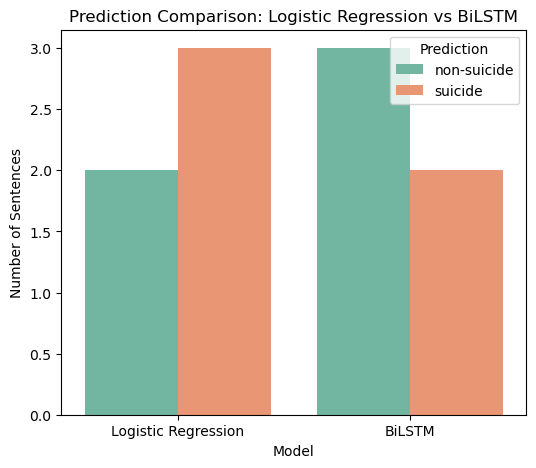

In [33]:

# Build a DataFrame from the sample sentences and predictions
df_results = pd.DataFrame([
    {
        "Sentence": s[:100]+"...",  # short preview
        "Logistic Regression": results[s]["Logistic Regression"],
        "BiLSTM": results[s]["BiLSTM"]
    }
    for s in results
])

print("Sample Predictions Table:\n")
print(df_results)

# Count predictions per class for each model
count_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Logistic Regression", "BiLSTM", "BiLSTM"],
    "Prediction": ["non-suicide", "suicide", "non-suicide", "suicide"],
    "Count": [
        list(df_results["Logistic Regression"]).count("non-suicide"),
        list(df_results["Logistic Regression"]).count("suicide"),
        list(df_results["BiLSTM"]).count("non-suicide"),
        list(df_results["BiLSTM"]).count("suicide"),
    ]
})

# Bar plot
plt.figure(figsize=(6,5))
sns.barplot(x="Model", y="Count", hue="Prediction", data=count_df, palette="Set2")
plt.title("Prediction Comparison: Logistic Regression vs BiLSTM")
plt.ylabel("Number of Sentences")
plt.show()


In [53]:
result = compare_models([
  "Sometimes I wish I would just disappear.",
  "Lately I don't see the point in getting out of bed.",
  "I keep thinking people would be better off without me.",
  "Maybe life would be easier if I wasn't here.",
  "There are days I wonder what would happen if I never showed up again.",
  "I don't want to hurt anyone, I just feel like a burden.",
  "Some nights I imagine not waking up, but I don't know what to do.",
  "I can't shake the thought that things will never get better.",
  "I feel so exhausted of living that it scares me.",
  "I've been having lots of dark thoughts lately and I don't know why.",
  "I find myself daydreaming about not existing anymore.",
  "I keep thinking about disappearing — I haven't told anyone."
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


In [54]:
df_final = pd.DataFrame.from_dict(result, orient='index')

In [55]:
df_final

,Logistic Regression,BiLSTM,Prediction
Sometimes I wish I would just disappear.,suicide,suicide,suicide
Lately I don't see the point in getting out of bed.,non-suicide,non-suicide,non-suicide
I keep thinking people would be better off without me.,suicide,suicide,suicide
Maybe life would be easier if I wasn't here.,suicide,suicide,suicide
There are days I wonder what would happen if I never showed up again.,non-suicide,non-suicide,non-suicide
"I don't want to hurt anyone, I just feel like a burden.",suicide,suicide,suicide
"Some nights I imagine not waking up, but I don't know what to do.",non-suicide,non-suicide,non-suicide
I can't shake the thought that things will never get better.,suicide,suicide,suicide
I feel so exhausted of living that it scares me.,suicide,suicide,suicide
I've been having lots of dark thoughts lately and I don't know why.,non-suicide,non-suicide,non-suicide


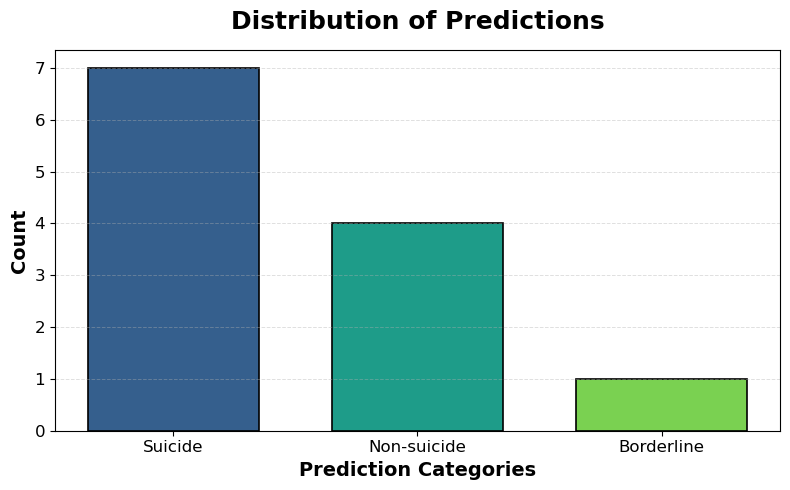

In [67]:


# Count prediction categories
prediction_counts = df_final["Prediction"].value_counts()
values = prediction_counts.values
labels = prediction_counts.index.str.capitalize()
x = np.arange(len(values))

plt.figure(figsize=(8, 5))

# Create gradient-like colored bars using a colormap
colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(values)))  # viridis gradient

bars = plt.bar(
    x,
    values,
    color=colors,
    edgecolor="black",
    linewidth=1.2,
    width=0.7
)

# Elegant labels and title
plt.xticks(x, labels, fontsize=12, fontweight="medium")
plt.yticks(fontsize=12)
plt.xlabel("Prediction Categories", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.title("Distribution of Predictions", fontsize=18, fontweight="bold", pad=15)

# Subtle horizontal grid
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.4)

plt.tight_layout()
plt.show()
